In [1]:
import torch
import sys
import os
sys.path.append(os.path.abspath('../..'))
from data import PVWeatherGenerator, SystemLoader


In [2]:
# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS_FOLD = 7
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 // MINUTE_INTERVAL
N_SYSTEMS = 6
CIRCLE_COORDS = (53.28, -3.05)
RADIUS = 0.25

In [3]:
generator = PVWeatherGenerator(
    coords=CIRCLE_COORDS,
    radius=RADIUS,
    day_init=DAY_INIT,
    n_systems=N_SYSTEMS,
    n_days=365,
    minute_interval=MINUTE_INTERVAL,
)
df = generator.df

==> Loading data
==> Loaded data in: 0 m : 19 sec



In [15]:
individual_interval = int(DAILY_DATA_POINTS * N_DAYS_FOLD)
loader = SystemLoader(df, train_interval=individual_interval)

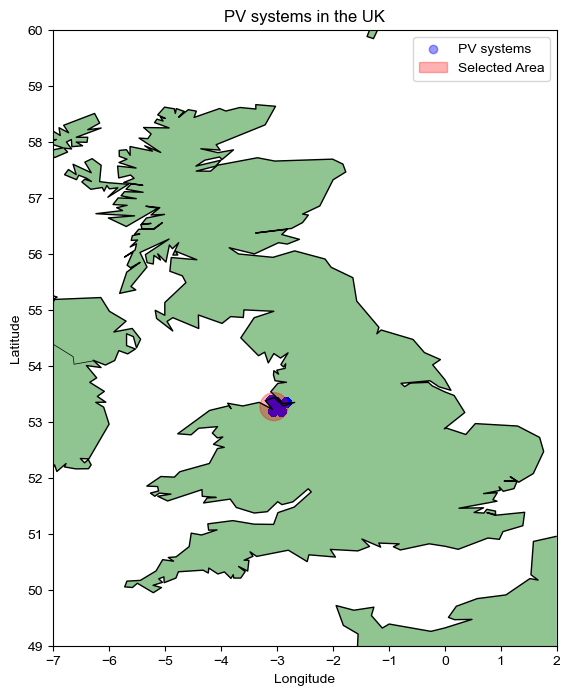

In [5]:
from pv_plot import plot_grid
CIRCLE_COORDS = (53.28, -3.05)
RADIUS = 0.25
plot_grid(df, CIRCLE_COORDS, RADIUS)

In [6]:
x, _,_,_,_,_ = next(iter(loader))
d = x.shape[1]
print(d)

6


In [20]:
from kernels import get_mean_covar_weather

num_tasks = N_SYSTEMS
num_latents = N_SYSTEMS // 2 + 1
mean, covar = get_mean_covar_weather(num_latents=num_latents,
                                      d=d,
                                      combine='product')

interval = 6

Using CPU
Iter 10/100 - Loss: 3.9977300609610875
Iter 20/100 - Loss: 1.0306279330204537
Iter 30/100 - Loss: -0.2539418660414985
Iter 40/100 - Loss: -0.8400228209184364
Iter 50/100 - Loss: -1.0593474481831304
Iter 60/100 - Loss: -1.1701540457957058
Iter 70/100 - Loss: -1.2215342764513768
Iter 80/100 - Loss: -1.2393651608362657
Iter 90/100 - Loss: -1.2479941225845959
Iter 100/100 - Loss: -1.2600273388772656


findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: 

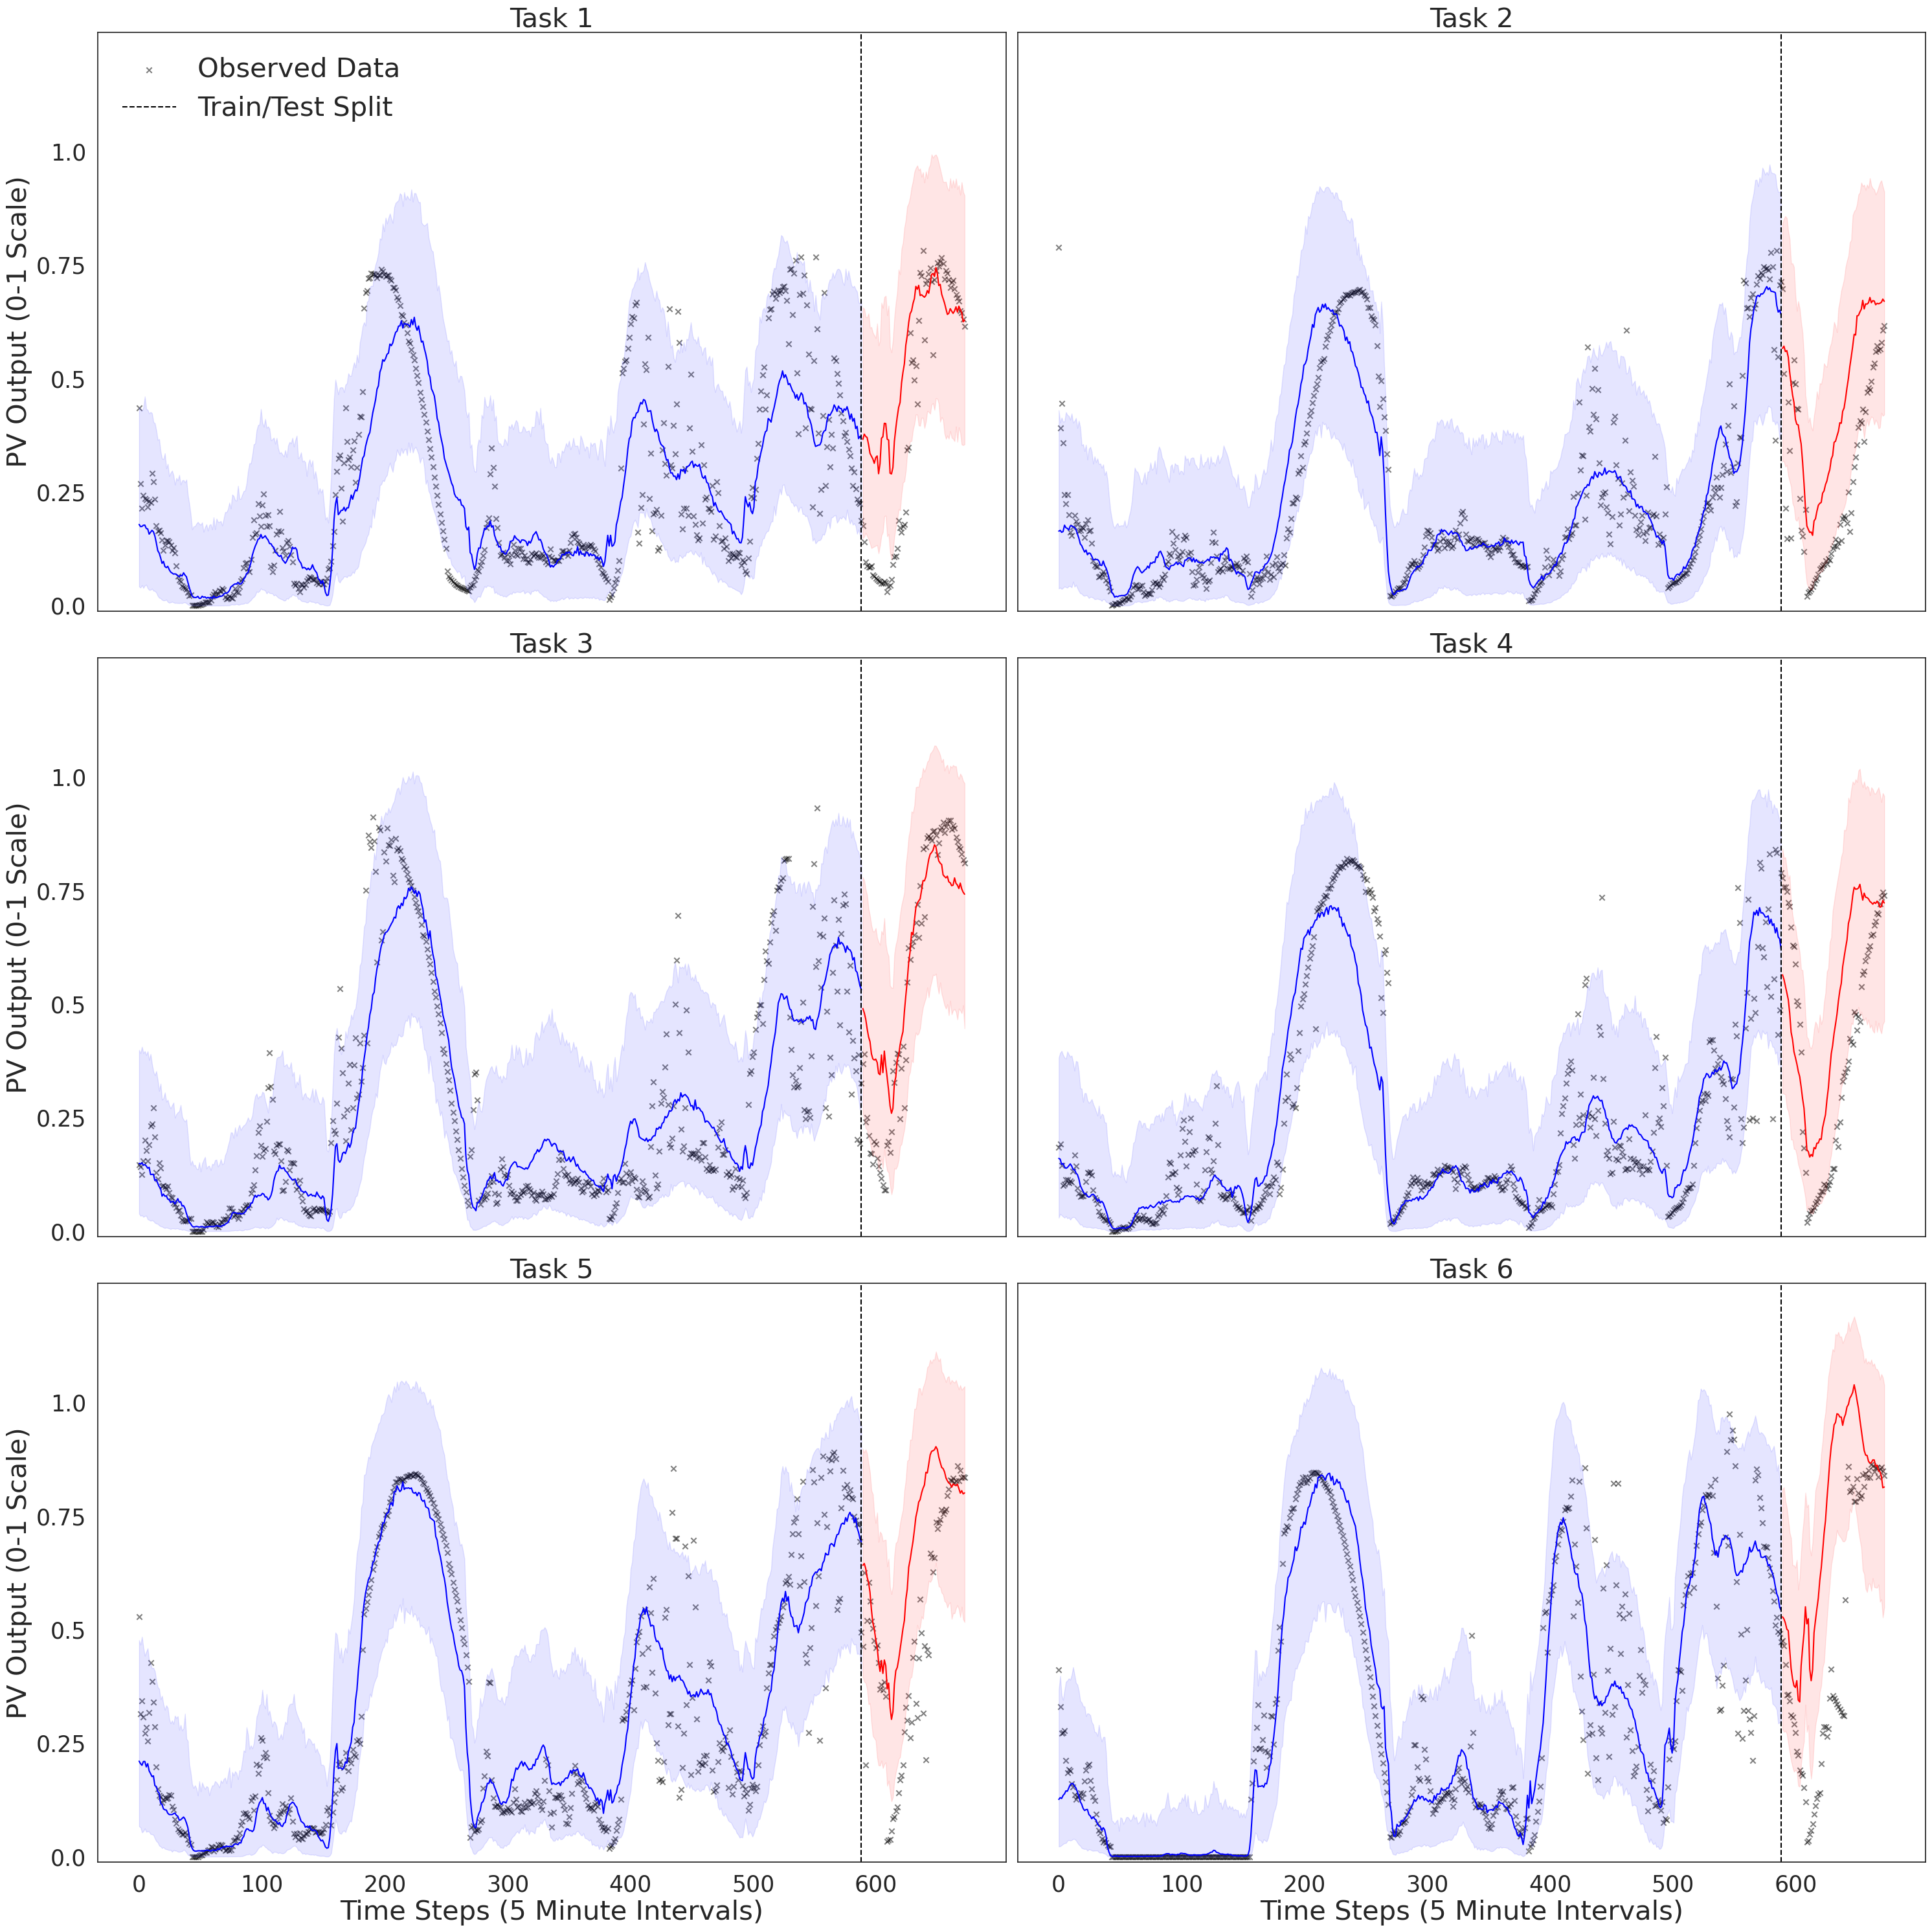

In [25]:
from matplotlib import pyplot as plt
import numpy as np
from models import HadamardGPModel
from likelihoods import HadamardBetaLikelihood

for X_tr, Y_tr, X_te, Y_te, T_tr, T_te in loader:
    fig, ax = plt.subplots(num_tasks // 2, 2, figsize=(30, 5 * (num_tasks)), sharex=True, sharey=True)
    plt.rcParams['font.serif'] = ['Times New Roman']

    ax = ax.flatten()
    mean, covar = get_mean_covar_weather(num_latents, d-1, combine='product', weather_kernel='matern')
    model = HadamardGPModel(
        X=X_tr[::interval],
        y=Y_tr[::interval],
        mean_module=mean,
        covar_module=covar,
        likelihood=HadamardBetaLikelihood(num_tasks=num_tasks, scale=20),
        num_tasks=num_tasks,
        num_latents=num_latents,
        learn_inducing_locations=True,
        inducing_proportion=1.0,
        jitter=1e-6,
    )
    model.set_cpu()
    model.fit(n_iter=100, 
          lr=0.2, 
          task_indices=T_tr[::interval],
          verbose=True)
    model.predict(X_tr, T_tr)
    

    for i in range(num_tasks):
        _, y_tr, _, y_te = loader.train_test_split_individual(i)
        n_tr, n_te = y_tr.shape[0], y_te.shape[0]
        t = torch.linspace(0, int(N_DAYS_FOLD * DAILY_DATA_POINTS), n_tr + n_te)
        t_tr, t_te = t[:n_tr], t[n_tr:]

        y_pred_tr, lower_tr, upper_tr = model.get_i_prediction(i, T_tr)
        ax[i].scatter(t_tr, y_tr, color='black', marker='x', label='Observed Data', alpha=0.5)
        ax[i].scatter(t_te, y_te, color='black', marker='x', alpha=0.5)
        ax[i].plot(t_tr, y_pred_tr, color='blue')
        ax[i].fill_between(t_tr, lower_tr, upper_tr, color='blue', alpha=0.1)
    
    model.predict(X_te, T_te)
    pred_dist = model.predict_dist()
  
    for i in range(num_tasks):
        x_tr, y_tr, x_te, y_te = loader.train_test_split_individual(i)
        n_tr, n_te = y_tr.shape[0], y_te.shape[0]
        t = torch.linspace(0, int(N_DAYS_FOLD * DAILY_DATA_POINTS), n_tr + n_te)
        t_tr, t_te = t[:n_tr], t[n_tr:]

        y_pred_te, lower_te, upper_te = model.get_i_prediction(i, T_te)
        if i == 0:
            ax[i].plot(t_te, y_pred_te, color='red')
            ax[i].fill_between(t_te, lower_te, upper_te, color='red', alpha=0.1)
        else:
            ax[i].plot(t_te, y_pred_te, color='red')
            ax[i].fill_between(t_te, lower_te, upper_te, color='red', alpha=0.1)
        ax[i].axvline(t_tr.max(), color='black', linestyle='--', label='Train/Test Split')
        ax[i].set_ylim(-0.01, 1.01)
        ax[i].set_title(f'Task {i+1}', fontsize=30)
       
        # set y label for left column
        if i % 2 == 0:
            ax[i].set_ylabel('PV Output (0-1 Scale)', fontsize=30)
            # add y ticks
            y_ticks = [0, 0.0, 0.25, 0.5, 0.75, 1.0]
            ax[i].set_yticklabels(y_ticks, fontsize=25)
        # set x label for bottom row
        if i >= num_tasks - 2:
            ax[i].set_xlabel('Time Steps (5 Minute Intervals)', fontsize=30)
            # add x ticks
            ax[i].set_xticklabels([0, 0, 100, 200, 300, 400, 500, 600], fontsize=25)
        
        if i == 0:
            ax[i].legend(fontsize=30)
      
    for i in range(num_tasks, len(ax)):
        ax[i].axis('off')
    break

plt.tight_layout()
plt.show()
